In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind

In [4]:
%matplotlib notebook

#### Load EEGexp object

In [5]:
rec_folder = r'W:\EEG_exp\mouse635397\opto_cortical_ctx_2022-08-19_11-10-25\experiment1\recording1' # points to folder containing stim_table.csv
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


#### Set variables

In [6]:
mask_probe = 'probeF'
surface_channel = 340 # estimate is fine

### Analysis

In [7]:
NUM_PLOT_CHANNELS = 8 # number of chs to select randomly and plot
TRIALS_PER_SWEEP = 3 # number of trials to select randomly from each sweep and plot
PLOT_WINDOW = 1000 # samples on either side of mask, must be larger than mask
PLOT_SEP = 2500 # y separation between chs

#### Load raw data

In [8]:
rawDatamm = np.memmap(exp.ephys_params[mask_probe]['ap_continuous'], dtype='int16', mode='r') # r+ will allow the file to be changed
datamm = np.reshape(rawDatamm, (int(rawDatamm.size / exp.ephys_params[mask_probe]['num_chs']), exp.ephys_params[mask_probe]['num_chs']))
timestamps = np.load(exp.ephys_params[mask_probe]['ap_timestamps'])

If there is a "permission denied" error here, try running mode='r' and then retry mode='r+'.

In [9]:
print(datamm.shape)
print(timestamps.shape)

(188042304, 384)
(188042304,)


#### Need to identify brain chs that are not ref chs, to randomly select from this subset.

In [10]:
if '-3a-' in exp.ephys_params[mask_probe]['ap_continuous']:
    print('probe is 3a')
    reference_channels = [36, 75, 112, 151, 188, 227, 264, 303, 340, 379]
else:
    print('probe is 1.0/PXI')
    reference_channels = [191]

probe is 1.0/PXI


In [11]:
brain_channels = np.setdiff1d(np.arange(surface_channel), reference_channels)
print(len(brain_channels))
# print(brain_channels)

339


#### Plot some chs and trials to check masking

In [12]:
plot_channels = np.sort(np.random.choice(brain_channels, NUM_PLOT_CHANNELS))
# plot_channels = np.sort(np.array([300, 312, 325, 337, 350, 355, 360]))
print(plot_channels)

[ 13  37  98 146 187 212 303 327]


#### Load stim log

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,opto,0,470nm,5,364.17634,364.18634,0.01,0
1,opto,1,470nm,5,369.39007,369.40007,0.01,0
2,opto,2,470nm,5,376.31433,376.32433,0.01,0
3,opto,3,470nm,5,381.32401,381.33401,0.01,0
4,opto,4,470nm,5,387.87427,387.88427,0.01,0


In [14]:
stim_types = np.unique(stim_log['stim_type'].values)
print(stim_types)

['470nm' 'biphasic']


In [15]:
sweeps = np.unique(stim_log['sweep'].values)
print(sweeps)

[0 1 2 3 4 5 6]


In [16]:
plot_sweep = 3
sweep_log = stim_log[stim_log['sweep'] == plot_sweep]
sweep_onsets = sweep_log['onset'].values

<IPython.core.display.Javascript object>


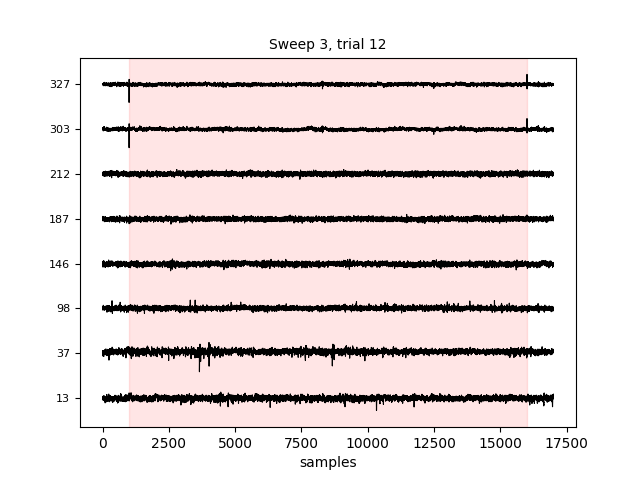

Text(0.5, 1.0, 'Sweep 3, trial 12')

In [17]:
plot_trial = 12

plot_onset_ind = find_nearest_ind(timestamps, sweep_onsets[plot_trial])
eventdur = sweep_log['duration'].values[plot_trial]
eventdurinds = int(eventdur * exp.ephys_params[mask_probe]['ap_sample_rate'])

plinds = np.arange(plot_onset_ind - PLOT_WINDOW, plot_onset_ind + eventdurinds + PLOT_WINDOW)
onindi = plot_onset_ind - plinds[0]
fig, ax = plt.subplots()
for ii, chi in enumerate(plot_channels):
    single_raw = datamm[plinds, chi] - np.mean(datamm[plinds[:50], chi])
    ax.plot(single_raw+PLOT_SEP*ii, 'k', linewidth=0.8)
    del single_raw
ax.axvspan(onindi, onindi + eventdurinds, alpha=0.1, color='red')
ax.set_xlabel('samples')
ax.get_yaxis().tick_left()
plt.yticks(range(0, ii*PLOT_SEP+1, PLOT_SEP), plot_channels, fontsize=8)
plt.title('Sweep {:d}, trial {:d}'.format(plot_sweep, plot_trial))

In [15]:
stim_mask_inds = []
for stimtypei in stim_types:
    if stimtypei in ['biphasic', 'estim']:
        stim_mask_inds.append(np.array(
            [find_nearest_ind(timestamps, x) for x in stim_log[stim_log['stim_type'] == stimtypei].onset.values]
        ))
    elif stimtypei in ['opto', 'estim_opto', '470nm']:
        stim_mask_inds.append(np.array(
            [find_nearest_ind(timestamps, x) for x in stim_log[stim_log['stim_type'] == stimtypei].onset.values]
        ))
        stim_mask_inds.append(np.array(
            [find_nearest_ind(timestamps, x) for x in stim_log[stim_log['stim_type'] == stimtypei].offset.values]
        ))
    else:
        print('{}: no masking applied'.format(stimtypei))

In [16]:
stim_mask_inds = np.sort(np.concatenate(stim_mask_inds))
stim_mask_inds.shape

(1800,)

In [17]:
stim_mask_inds

array([ 10492184,  10492484,  10648596, ..., 186726313, 186729312,
       186741313], dtype=int64)

In [18]:
mask_onset_inds = stim_mask_inds - 2 # this corrects for minimal sample offset between estim_times and actual beginning of artifact

In [22]:
stim_sweeps = np.sort(stim_log[stim_log['stim_type'] == '470nm'].sweep.unique())

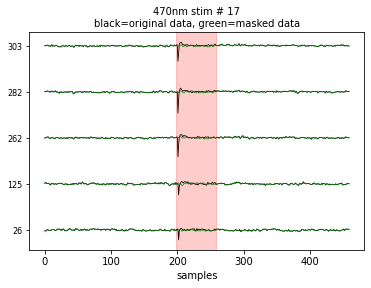

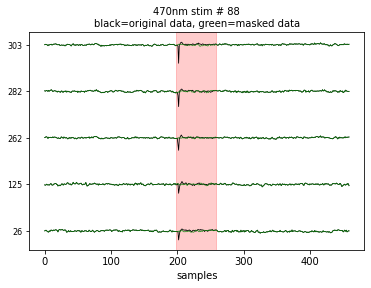

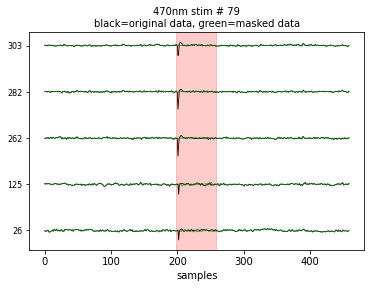

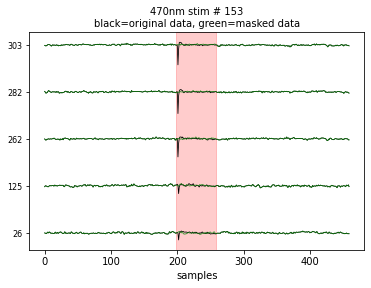

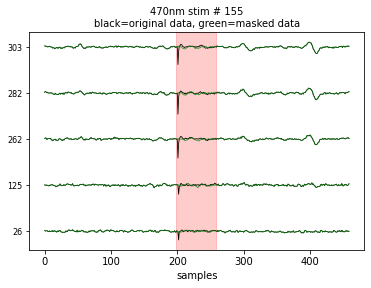

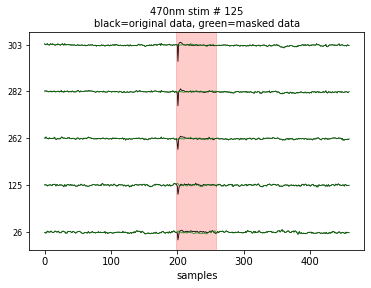

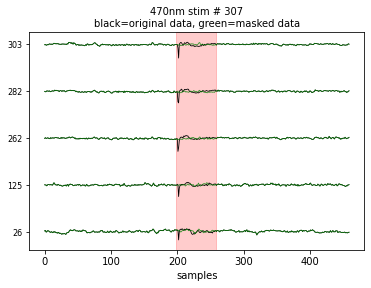

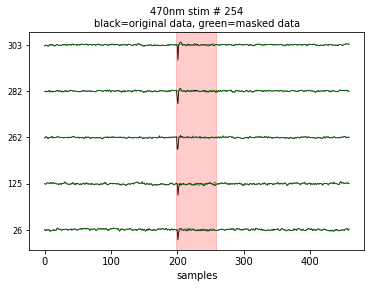

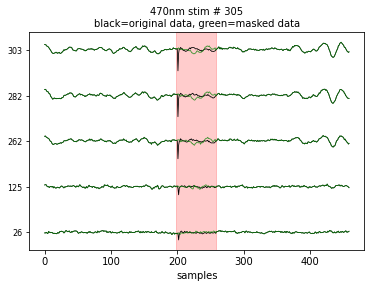

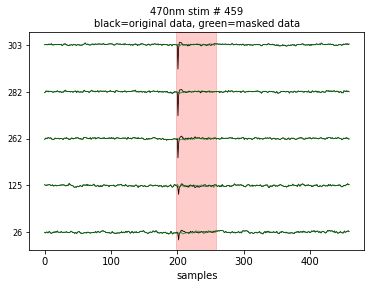

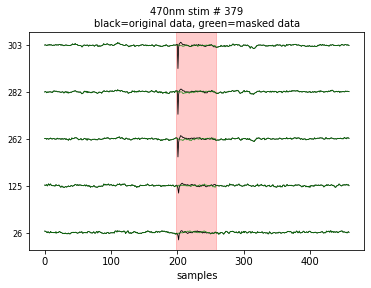

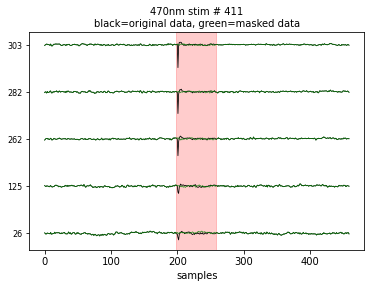

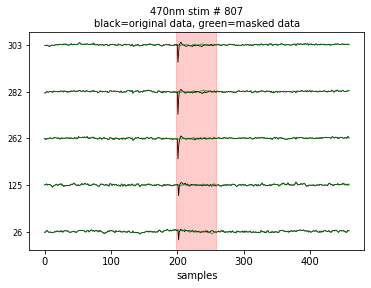

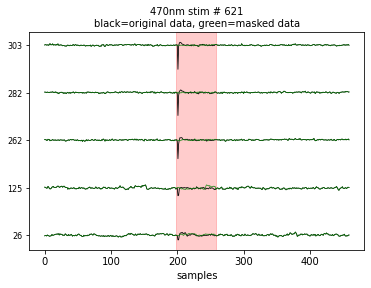

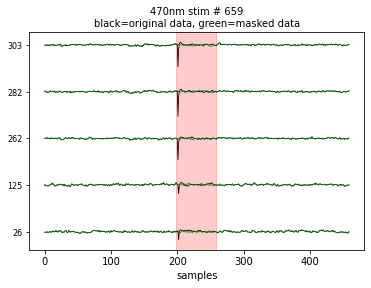

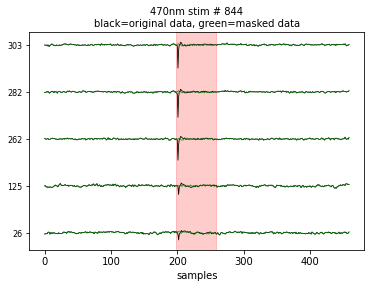

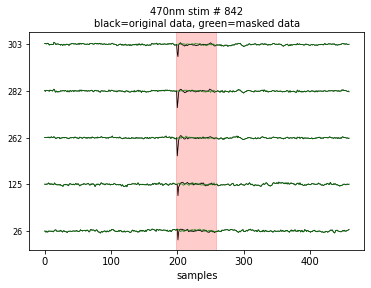

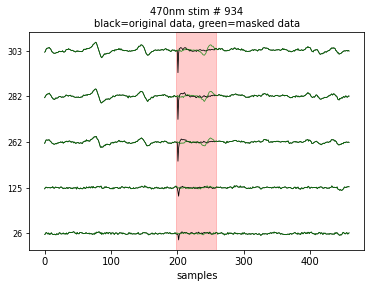

In [25]:
## Make the plots ##
for sweep_num in stim_sweeps:
    all_stim_times = stim_log[(stim_log['stim_type'] == '470nm') & (stim_log['sweep'] == sweep_num)].onset.values
    for timei in np.random.choice(all_stim_times, TRIALS_PER_SWEEP):
        rowi = stim_log[stim_log['onset'] == timei]
        stim_indi = find_nearest_ind(timestamps, timei)
        plinds = np.arange(stim_indi - PLOT_WINDOW, stim_indi + mask_samples + PLOT_WINDOW)
        mask_indi = stim_indi - plinds[0] - 2
        fig, ax = plt.subplots()
        for ii, chi in enumerate(plot_channels):
            single_raw = datamm[plinds, chi] - np.mean(datamm[plinds[:50], chi])
            single_clean = np.copy(single_raw)
            single_clean[mask_indi:mask_indi+mask_samples] = single_clean[mask_indi:mask_indi-mask_samples:-1]
            ax.plot(single_raw+PLOT_SEP*ii, 'k', linewidth=0.8)
            ax.plot(single_clean+PLOT_SEP*ii, 'g', alpha=0.8, linewidth=0.8)
            del single_raw
            del single_clean
        ax.axvspan(mask_indi, mask_indi+mask_samples, alpha=0.2, color='red')
        ax.set_xlabel('samples')
        ax.get_yaxis().tick_left()
        plt.yticks(range(0, ii*PLOT_SEP+1, PLOT_SEP), plot_channels, fontsize=8)
        plt.title('%s stim # %d\nblack=original data, green=masked data' % (rowi.stim_type.values[0], rowi.index.values[0]))
        plt.show()

End of plotting

### Apply the mask!

In [ ]:
start = time.time()

mask_onset_times = np.zeros_like(mask_onset_inds, dtype='float64')
for ind, val in enumerate(mask_onset_inds):
    if np.isnan(val):
        mask_onset_times[ind] = np.nan
        continue
    else:
        val = int(val)
        datamm[val:val+mask_samples,:] = datamm[val:val-mask_samples:-1,:] # now this is 2D
        mask_onset_times[ind] = timestamps[val]
#         datamm[val:val+(mask_samples+30),:] = datamm[val:val-(mask_samples+30):-1,:]

end = time.time()
print(end-start)

### Flush the results to disk (this actually alters the original file, be careful)

In [ ]:
del(datamm)
del(rawDatamm)

#### Save artifact_onset and mask_duration as .npy inside probe folder

In [ ]:
artifact_file = Path(artinds_path)
if artifact_file.is_file():
    print('Artifact onset files already exist')
else:
    np.save(artinds_path, mask_onset_inds, allow_pickle=False)
    np.save(arttimes_path, mask_onset_times, allow_pickle=False)
    np.save(maskdur_path, mask_samples, allow_pickle=False)
    print('Artifact files saved to probe folder')